In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from impyute.imputation.cs import mice
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, confusion_matrix
from xgboost import XGBClassifier
from xgboost import plot_importance

import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, f1_score, precision_recall_curve
import itertools
from pandas_datareader import data as pdr
import yfinance as yf
import datetime

In [28]:
def longshort(df,yearinput):
    df=df.sort_values(by='1', ascending=False)
    df['quantile'] = pd.qcut(df['1'],10, labels=["1", "2", "3",'4','5','6','7','8','9','10'])
    #store the needed GVKEY into a list
    masklow=df['quantile']=='10'
    lowlist= list(df[masklow]['GVKEY'])

    maskhigh=df['quantile']=='1'
    highlist= list(df[maskhigh]['GVKEY'])
    
    #all_fund and time reduction 
    all_fund = pd.read_csv('all_companies_fund.csv')
    all_fund['datadate']=(pd.to_datetime(all_fund['datadate']))
    all_fund['month']= all_fund['datadate'].dt.month
    all_fund['year']= all_fund['datadate'].dt.year
    maskyear= all_fund['year']>=yearinput
    all_fund=all_fund[maskyear]
    
    
    #mask to only check the one in qcut
    maskhigh= all_fund['GVKEY'].isin(highlist)
    highdata=all_fund[maskhigh]

    masklow= all_fund['GVKEY'].isin(lowlist)
    lowdata=all_fund[masklow]
    
    
    #create longshort portfolio
    mask = highdata['GVKEY']==highdata['GVKEY'].shift(-1)
    highdata['mkvalt_next']= np.where(mask,highdata['mkvalt'].shift(-1),np.nan)
    mask = lowdata['GVKEY']==lowdata['GVKEY'].shift(-1)
    lowdata['mkvalt_next']= np.where(mask,lowdata['mkvalt'].shift(-1),np.nan)
    
    #calculate market return 
    highdata['return']= (highdata['mkvalt_next']-highdata['mkvalt'])*100/highdata['mkvalt']
    lowdata['return']= (lowdata['mkvalt_next']-lowdata['mkvalt'])*100/lowdata['mkvalt']
    # Shift the stock by 1 month
    mask = highdata['GVKEY']==highdata['GVKEY'].shift(-1)
    highdata['nextmonth_return']= np.where(mask,highdata['return'].shift(-1),np.nan)

    # Shift the stock by 1 month
    mask = lowdata['GVKEY']==lowdata['GVKEY'].shift(-1)
    lowdata['nextmonth_return']= np.where(mask,lowdata['return'].shift(-1),np.nan)
    
    
    #equal weight portfolio 
    highdata.groupby(['year','month'])[['nextmonth_return']].agg('mean')
    lowdata.groupby(['year','month'])[['nextmonth_return']].agg('mean')
    long_short= (highdata.groupby(['year','month'])[['nextmonth_return']].agg('mean'))-(lowdata.groupby(['year','month'])[['nextmonth_return']].agg('mean'))
    long_short=long_short.reset_index()
    
    #filterout not used year 
    mask= long_short['year']==yearinput
    long_short= long_short[mask]
    long_short['date']=pd.to_datetime(long_short[['year', 'month']].assign(Day=1))
    return(highdata.groupby(['year','month'])[['nextmonth_return']].agg('mean'))

In [30]:
longshort(pd.read_csv('port2012.csv',index_col=0),2012)

C:\Users\Derrick\Anaconda2\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Derrick\Anaconda2\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Derrick\Anaconda2\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

nextmonth_return
year month                  
2012 3             29.520818
     12             2.883674
2013 3                   NaN
     12            -4.661257
2014 3                   NaN
     12            16.602263
2015 12             5.629883
2016 12           -16.348435
2017 12            33.637532
2018 12                  NaN
2019 12                  NaN

In [19]:

file_name = 'port{}.csv'
df_list = []
for i in range(2011, 2018):
    df_list.append(longshort(pd.read_csv(file_name.format(i), index_col=0),i))

df = pd.concat(df_list)

C:\Users\Derrick\Anaconda2\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Derrick\Anaconda2\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Derrick\Anaconda2\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

In [20]:
df

,year,month,nextmonth_return,date
0,2011,3,27.888798,2011-03-01
1,2011,6,-75.158470,2011-06-01
2,2011,9,-17.841870,2011-09-01
3,2011,12,-119.338644,2011-12-01
0,2012,3,-79.817857,2012-03-01
1,2012,6,NaN,2012-06-01
2,2012,9,NaN,2012-09-01
3,2012,12,-2.594225,2012-12-01
0,2013,3,NaN,2013-03-01
1,2013,6,-24.795242,2013-06-01


In [21]:
df.to_csv('Equal_weight.csv')

## SP500 Regression 

In [22]:
from pandas_datareader import data as pdr
import yfinance as yf
import datetime

start_sp = datetime.datetime(1998, 1 , 1)
end_sp = datetime.datetime(2020, 1, 31)


yf.pdr_override() # <== that's all it takes :-)
sp500 = pdr.get_data_yahoo('^GSPC', 
                           start_sp,
                             end_sp)
sp500= sp500.reset_index()

sp500['year']=sp500['Date'].dt.year
sp500['month']=sp500['Date'].dt.month

sp500=sp500.drop_duplicates(subset=['year','month'], keep="last")

sp500['next_month_close']= sp500['Adj Close'].shift(-1)
sp500['mkt_return']= (sp500['next_month_close']-sp500['Adj Close'])*100/sp500['Adj Close']

[*********************100%***********************]  1 of 1 completed


In [23]:
#merge dataframe 
regressiondata= pd.merge(df,sp500, left_on=['year','month'], right_on=['year','month'], how='left')

In [24]:
mask= regressiondata['nextmonth_return'].isnull()|regressiondata['mkt_return'].isnull()

In [25]:
import statsmodels.api as sm
x=regressiondata[~mask]['mkt_return']
y=regressiondata[~mask]['nextmonth_return']
x = sm.add_constant(x)

C:\Users\Derrick\Anaconda2\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [26]:
model = sm.OLS(y,x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       nextmonth_return   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                 -0.060
Method:                 Least Squares   F-statistic:                    0.1545
Date:                Tue, 03 Mar 2020   Prob (F-statistic):              0.700
Time:                        15:15:31   Log-Likelihood:                -82.716
No. Observations:                  16   AIC:                             169.4
Df Residuals:                      14   BIC:                             171.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -15.0397     12.313     -1.221      0.2

C:\Users\Derrick\Anaconda2\lib\site-packages\scipy\stats\stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))


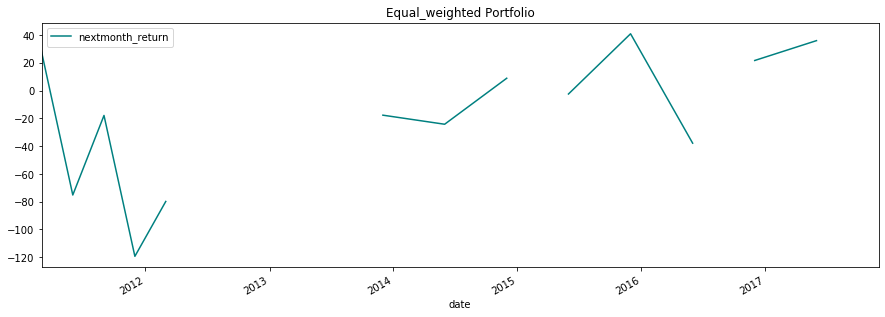

In [27]:
ax = df.plot(x = 'date', y = 'nextmonth_return', title = 'Equal_weighted Portfolio', color = 'teal', figsize = (15,5))